In [1]:
#Necessary imports
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras import activations # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Tensorflow vs Pytorch

In [ ]:
# Input: used to instantiate a Keras tensor for the input to the model
# Conv2D: Convolutional layer that applies a 2D convolution over an input signal
# MaxPooling2D: Max pooling operation for spatial data, used to downsample the input representation, reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned
# ZeroPadding2D: Add rows and columns of zeros at the top, bottom, left and right side of an image tensor
# Flatten: Flattens the input, converts it to a 1D array
# BatchNormalization: Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1

**Reading Data from CSV file**

In [3]:
with open("data/Crowd-Emotion.csv") as f:
    content = f.readlines()

In [5]:
# len(content)
lines = np.array(content)

In [8]:
# lines.shape, lines.size, lines.ndim

In [9]:
num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("Image size: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
Image size:  2304


**Splitting data into training and testing**

In [10]:
x_train, x_trainlabel, x_test, x_testlabel = [], [], [], []
num_classes = 7

In [11]:
for i in range(1,num_of_instances):
  emotion, img, usage = lines[i].split(",")
  val = img.split(" ")
  val = [int(i) for i in val if i!='']
  pixels = np.array(val, 'float32')
  emotion = keras.utils.to_categorical(emotion, num_classes)
  if 'Training' in usage or 'PrivateTest' in usage:  
    x_trainlabel.append(emotion)
    x_train.append(pixels)
  elif 'PublicTest' in usage:
    x_testlabel.append(emotion)
    x_test.append(pixels)
    
    

In [23]:
# x_train[1000], x_trainlabel[1000]

**Normalizing the pixel values**

In [17]:
x_train = np.array(x_train, 'float32')
x_trainlabel = np.array(x_trainlabel, 'float32')
x_test = np.array(x_test, 'float32')
x_testlabel = np.array(x_testlabel, 'float32')
x_test_flattened = [np.argmax(i) for i in x_testlabel]
x_test_flattened = np.array(x_test_flattened)

In [18]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

In [19]:
print(num_of_instances, 'total samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

35888 total samples
32298 train samples
3589 test samples


In [20]:
print("Shape of train data:" ,x_train.shape)
print(x_trainlabel.shape)
print("Shape of test data:",x_test.shape)
print(x_testlabel.shape)

Shape of train data: (32298, 48, 48, 1)
(32298, 7)
Shape of test data: (3589, 48, 48, 1)
(3589, 7)


**Performing Data Augumentation**

In [21]:
##Include Little Data Augmentation 
batch_size = 256 
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
train_set_conv = train_DataGen.flow(x_train, x_trainlabel, batch_size=batch_size) 

In [11]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 50

**ResNet-50 Architecture**

In [12]:
def res_identity(x, filters): 
    x_skip = x # skip connection
    f1, f2 = filters
    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)
    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [13]:
def res_conv(x, s, filters):
    '''
    here the input size changes, when it goes via conv blocks
    so the skip connection uses a projection (conv layer) matrix
    ''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [14]:
### Combine the above functions to build 50 layers resnet. 
def resnet50():

    input_im = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage
    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage
    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage
    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection
    x = AveragePooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 
    model = Model(inputs=input_im, outputs=x, name='Resnet50')
    return model

In [15]:
resnet50_model = resnet50()

In [16]:
resnet50_model.summary()

Model: "Resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 54, 54, 1) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │      3,200 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 24,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 11, 11,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 11, 11,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 11, 11,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 11, 11,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 11, 11,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 11,    │          0 │ batch_normalizat

 Total params: 23,595,783 (90.01 MB)

 Trainable params: 23,542,663 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [18]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('lr: ', lr)
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  
def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop

In [19]:
batch_size=batch_size
steps_per_epoch = int(x_train.shape[0] / batch_size)

print("Steps per epoch: ",steps_per_epoch)
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=10, 
                                  steps_per_epoch=steps_per_epoch,
                                  callbacks=[lrdecay])

Steps per epoch:  126
lr:  0.001
Epoch 1/10


/Users/ehtishamsadiq/Crowd-Emotion-Recognition/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - acc: 0.2359 - loss: 19.4026 - learning_rate: 0.0010
lr:  0.001
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 924us/step - acc: 0.3086 - loss: 12.7139 - learning_rate: 0.0010
lr:  0.001
Epoch 3/10


2024-06-04 02:16:26.673192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


126/126 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - acc: 0.3402 - loss: 11.2367 - learning_rate: 0.0010
lr:  0.001
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 438us/step - acc: 0.3359 - loss: 7.7749 - learning_rate: 0.0010
lr:  0.001
Epoch 5/10


2024-06-04 02:23:57.215587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - acc: 0.3643 - loss: 7.1269 - learning_rate: 0.0010
lr:  0.001
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 704us/step - acc: 0.4531 - loss: 5.3433 - learning_rate: 0.0010
lr:  0.001
Epoch 7/10


2024-06-04 02:33:24.827728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - acc: 0.3017 - loss: 5.4939 - learning_rate: 0.0010
lr:  0.001
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 385us/step - acc: 0.3086 - loss: 4.8086 - learning_rate: 0.0010
lr:  0.001
Epoch 9/10


2024-06-04 02:40:52.728366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


126/126 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - acc: 0.3583 - loss: 4.5112 - learning_rate: 0.0010
lr:  0.001
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 327us/step - acc: 0.3945 - loss: 4.0987 - learning_rate: 0.0010


2024-06-04 02:49:09.448787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


**Accuracy obtained**

In [20]:
train_score = resnet50_model.evaluate(x_train, x_trainlabel, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = resnet50_model.evaluate(x_test, x_testlabel, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 4.0728583335876465
Train accuracy: 31.51278793811798
Test loss: 4.08001184463501
Test accuracy: 31.707996129989624


**Saving and loading the model**

In [21]:
resnet50_model.save("models/resnet50_tt_fermod_68.h5") 

In [22]:
from keras.models import load_model 
resnet50_model = load_model("models/resnet50_tt_fermod_68.h5") 
# trainloss , trainaccuracy = resnet50_model.evaluate(x_train,x_trainlabel)
# testloss, testaccuracy = resnet50_model.evaluate(x_test, x_testlabel) 
# print('Train loss:', trainloss)
# print('Train accuracy:', 100*trainaccuracy)
# print('Test loss:', testloss)
# print('Test accuracy:', 100*testaccuracy)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def classification(predictions): 
    class_types = ['angry', 'disgust', 'fear', 'happy', 'sad',
               'surprise', 'neutral']
    print("Classification Report:\n")
    cr=classification_report(x_test_flattened,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)

In [24]:
pred_class_resnet50 = resnet50_model.predict(x_test)

classification(pred_class_resnet50)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step
Classification Report:

              precision    recall  f1-score   support

       angry       0.14      0.98      0.24       467
     disgust       0.00      0.00      0.00        56
        fear       0.00      0.00      0.00       496
       happy       0.83      0.25      0.39       895
         sad       0.00      0.00      0.00       653
    surprise       0.00      0.00      0.00       415
     neutral       0.00      0.00      0.00       607

    accuracy                           0.19      3589
   macro avg       0.14      0.18      0.09      3589
weighted avg       0.22      0.19      0.13      3589



/Users/ehtishamsadiq/Crowd-Emotion-Recognition/myvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ehtishamsadiq/Crowd-Emotion-Recognition/myvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ehtishamsadiq/Crowd-Emotion-Recognition/myvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step


Text(95.72222222222221, 0.5, 'Expected')

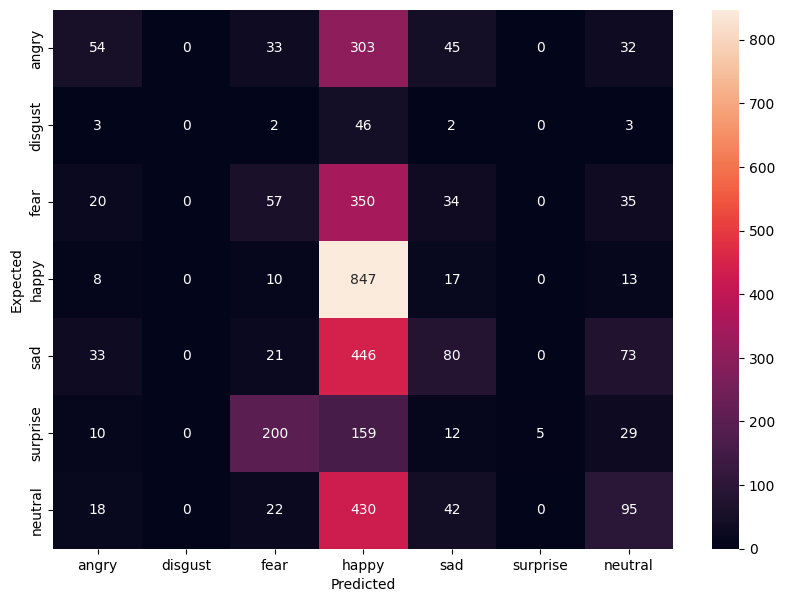

In [25]:
class_types = ['angry', 'disgust', 'fear', 'happy', 'sad',
               'surprise', 'neutral']
x_predicted = resnet50_model.predict(x_test)
x_predicted_labels = [np.argmax(i) for i in x_predicted]
cm = tf.math.confusion_matrix(labels=x_test_flattened,predictions=x_predicted_labels)

plt.figure(figsize = (10,7))
sns_hmp = sns.heatmap(cm, annot=True,xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Expected')
#fig = sns_hmp.get_figure()
#fig.savefig('/content/drive/MyDrive/graphs/confusion_matrix', dpi=250)
    


**Testing an image**

In [37]:
# def emotion_analysis(emotions):
#     objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
#     y_pos = np.arange(len(objects))
    
#     plt.bar(y_pos, emotions, align='center', alpha=0.5)
#     plt.xticks(y_pos, objects)
#     plt.ylabel('percentage')
#     plt.title('emotion')
    
#     plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    sns.set(style="whitegrid")
    sns.barplot(x=objects, y=emotions, palette="viridis")
    plt.ylabel('Percentage')
    plt.title('Emotion Analysis')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


/var/folders/qb/lf_2q09x7wj115gvfnkv6tkm0000gn/T/ipykernel_2720/538228514.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=objects, y=emotions, palette="viridis")


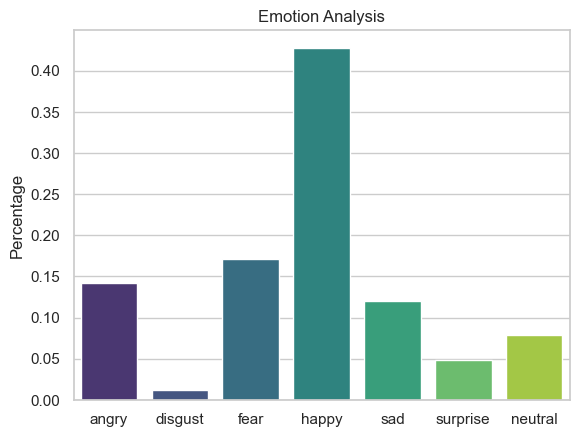

[0.14207245 0.01154843 0.17140274 0.4278186  0.11974683 0.04847473
 0.07893622]


In [38]:
import cv2
import math
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator


d = {0:"angry",1:"disgust",2:"fear",3:"happiness",4:"sad",5:"surprise",6:"neutral"}
face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_alt.xml')


file = 'Pictures/test_image_1.jpeg'
true_image = image.load_img(file)
t_image = cv2.imread(file)
#img = image.load_img(file, grayscale=True, target_size=(48, 48))
gray = cv2.cvtColor(t_image,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,1.1,4)

if(len(faces) == 0):
    exit()

for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    start_row,end_row,start_col,end_col = y,y+h,x,x+h

croppedimage = gray[start_row:end_row,start_col:end_col]
img = cv2.resize(croppedimage,(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = resnet50_model.predict(x)
emotion_analysis(custom[0])
print(custom[0])



In [34]:
emt = list(custom[0])
idx = emt.index(max(emt))
imgname = d[idx]
print(f"Emotion in the image is : {imgname}")

Emotion in the image is : happiness


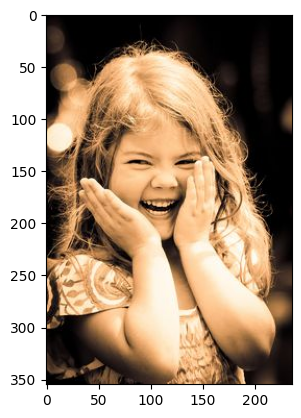

In [33]:
x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

**Testing a video sample**

In [28]:
def getFrame(seconds):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,seconds*1000)
    hasFrames,img = vidcap.read()
    
    if hasFrames:
        minutes = "00"
        hours = "00"
        if seconds >= 60:
            minutes = str(seconds//60)
            seconds = seconds % 60

        if int(minutes) >= 60:
            hours = str(int(minutes)//60)
            minutes = str(int(minutes) % 60)

        min = "{:02d}".format(int(minutes))
        sec = "{:02d}".format(seconds)
        hrs = "{:02d}".format(int(hours))

        flag = 0 
        frameId = vidcap.get(1)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,1.1,4)
        
        if(len(faces)==0):
            flag = 1
        
        if flag == 0 :
            global count
            count = count + 1
            for (x,y,w,h) in faces:
                cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
                start_row,end_row,start_col,end_col = y,y+h,x,x+h  
            
            croppedimage = gray[start_row:end_row,start_col:end_col]
            finalimg = cv2.resize(croppedimage,(48,48))

            x = image.img_to_array(finalimg)
            x = np.expand_dims(x, axis = 0)

            x /= 255

            custom = resnet50_model.predict(x)
            emt = list(custom[0])
            idx = emt.index(max(emt))
            imgname = d[idx]
            dcount[imgname] = dcount[imgname] + 1
            
            cv2.imwrite("/data/" + "%d_" % count +imgname+"__"+ hrs+":"+min+":"+sec+".jpg" ,img) 
    
    return hasFrames




In [29]:
import cv2
import math
from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator

videoFile = "/Users/ehtishamsadiq/Crowd-Emotion-Recognition/backend/data/emotion_recognition_test_video.mp4"
vidcap = cv2.VideoCapture(videoFile)

d = {0:"angry",1:"disgust",2:"fear",3:"happiness",4:"sad",5:"surprise",6:"neutral"}
dcount = {"angry":0,"disgust":0,"fear":0,"happiness":0,"sad":0,"surprise":0,"neutral":0}

face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_alt.xml')
count = 0

sec = 0
frameRate = 3 #it will capture image in each 2 second
success = getFrame(sec)
while success:
    sec = sec + frameRate
    #sec = round(sec, 2)
    success = getFrame(sec)

print ("Done!")
print("Extracted images:",count)
print(dcount)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Done!
Extracted images: 1
{'angry': 0, 'disgust': 0, 'fear': 0, 'happiness': 1, 'sad': 0, 'surprise': 0, 'neutral': 0}


**Plotting a bar chart of predicted emotions**

In [39]:
emotions = list(dcount.keys())
values = list(dcount.values())

/var/folders/qb/lf_2q09x7wj115gvfnkv6tkm0000gn/T/ipykernel_2720/12789532.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=objects, y=emotions, palette="viridis")


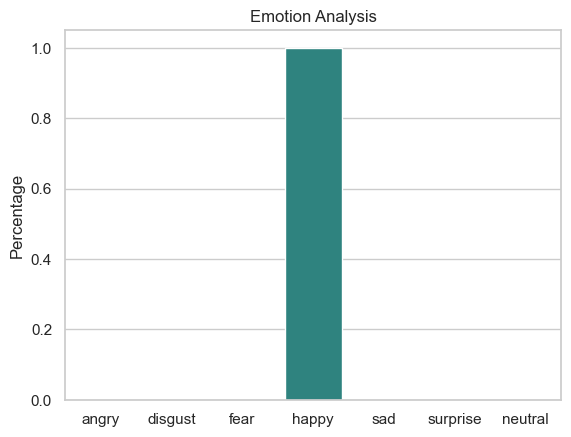

In [43]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    sns.set(style="whitegrid")
    sns.barplot(x=objects, y=emotions, palette="viridis")
    plt.ylabel('Percentage')
    plt.title('Emotion Analysis')
    plt.show()
    
emotion_analysis(values)

In [45]:
# emotion = None
# emotions = list(dcount.keys())
# values = list(dcount.values())
# for key, value in dcount.items():
#     if value == max(values):
#         emotion = key
        
# emotion

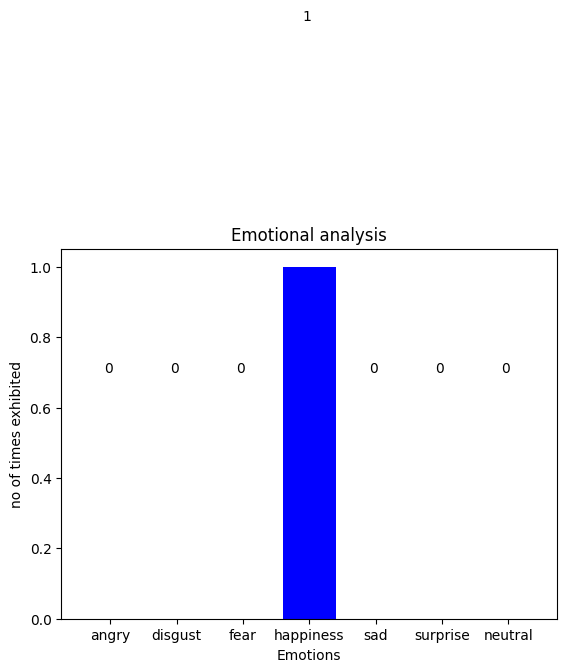

In [30]:


fig, ax = plt.subplots() 
width = 0.8
ind = np.arange(len(values)) 

plt.bar(emotions, values, width, color ='blue') 
        
for index, value in enumerate(values): 
    ax.text(index - 0.1, value + 0.70, str(value)) 
  
plt.xlabel("Emotions")
plt.ylabel("no of times exhibited")
plt.title("Emotional analysis")
plt.show()

In [ ]:
!pip install python-docx

**Creating a summary report**

In [ ]:
from docx import document

In [ ]:
from docx import Document
from docx.shared import Inches
from docx.shared import RGBColor
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

document = Document()
p1 = document.add_paragraph()
paragraph_format = p1.paragraph_format
paragraph_format.alignment = WD_ALIGN_PARAGRAPH.CENTER
p12 = p1.add_run("REPORT ON EMOTIONS PREDICTED")
f1 = p12.font
f1.size = Pt(16)
f1.underline = True
f1.bold = True

paragraph_format.line_spacing = 1.75

p2 = document.add_paragraph()
p22 = p2.add_run("Name of the video:")
f2 = p22.font
f2.name = 'Calibri'
f2.size = Pt(14)
f2.bold = True
p2.add_run(" video.mp4").font.size = Pt(13)


p3 = document.add_paragraph()
p32 = p3.add_run("Frames extracted link:")
f3 = p32.font
f3.name = 'Calibri'
f3.size = Pt(14)
f3.bold = True
document.add_paragraph('https://drive.google.com/drive/folders/1yw7eNLjjoUXOa2YMe1fFPNPyBuec45dm?usp=sharing')
document.add_paragraph("(Frames are extracted every 2 seconds)")

p4 = document.add_paragraph()
p42 = p4.add_run("Types of emotions predicted")
f4 = p42.font
f4.name = 'Calibri'
f4.size = Pt(14)
f4.bold = True
document.add_paragraph('Angry', style='List Bullet')
document.add_paragraph('Disgust', style='List Bullet')
document.add_paragraph('Fear', style='List Bullet')
document.add_paragraph('Happy', style='List Bullet')
document.add_paragraph('Sad', style='List Bullet')
document.add_paragraph('Surprise', style='List Bullet')
document.add_paragraph('Neutral', style='List Bullet')

p5 = document.add_paragraph()
p52 = p5.add_run("DETAILED ANALYSIS")
f5 = p52.font
f5.size = Pt(14)
f5.underline = True
f5.bold = True

p = document.add_paragraph()
p.add_run('Frequency graph:').bold = True
p.add_run(" No of times the person exhibited a particular emotion")

print("Report created successfully")

document.add_picture('data/frequency.png', width=Inches(5.25))
document.save('/content/drive/MyDrive/graphs/emotion_report.docx')






In [ ]:
import cv2
import numpy as np

# Create a video writer object
video_filename = "data/crowd_emotion_test_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
fps = 30
frame_size = (640, 480)
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, frame_size)

# Create a simple 2-second video with 60 frames (2 seconds at 30 fps)
for _ in range(60):
    # Create a blank frame with a solid color background
    frame = np.zeros((480, 640, 3), dtype=np.uint8)
    frame[:] = (0, 255, 0)  # Green background

    # Draw some text in the frame
    cv2.putText(frame, "Crowd Emotion Test", (50, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Write the frame to the video
    video_writer.write(frame)

# Release the video writer object
video_writer.release()

print(f"Video saved as {video_filename}")


In [ ]:
# !pip3 install py-feat

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [ ]:
# from feat.detector import Detector
# detector = Detector(verbose=True)
# detector


import os
import torch
from feat import Detector
import requests

def download_model(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print("Model downloaded successfully.")
    except Exception as e:
        print(f"Error downloading the model: {e}")

def load_model(model_path, device):
    try:
        model = resmasking_dropout1(in_channels=3, num_classes=7)
        model.load_state_dict(torch.load(model_path, map_location=device)['net'])
        model.eval()
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading the model: {e}")
        return None

# Define the model URL and the path where it will be saved
model_url = "models/ResMaskNet_Z_resmasking_dropout1_rot30.pth"
model_path = os.path.join(get_resource_path(), "ResMaskNet_Z_resmasking_dropout1_rot30.pth")

# Download the model file if it does not exist
if not os.path.exists(model_path):
    download_model(model_url, model_path)

# Initialize the detector with the loaded model
detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
)

detector.emotion_model = load_model(model_path, detector.device)


In [ ]:
from feat import Detector

In [ ]:
detector = Detector(
    face_model="mtcnn",
    # landmark_model="mobilenet",
    # au_model='svm',
    # emotion_model="resmasknet",
    # facepose_model="img2pose",
)
detector

In [ ]:
!pip install git+https://github.com/sajjjadayobi/FaceLib.git

In [ ]:
from facelib import FaceDetector, EmotionDetector
face_detector = FaceDetector(face_size=(224, 224))
emotion_detector = EmotionDetector()

In [ ]:
import matplotlib.pyplot as plt
image = '/Users/ehtishamsadiq/Crowd-Emotion-Recognition/backend/Pictures/test_image_1.jpeg'
image = plt.imread(image)

In [ ]:
faces, boxes, scores, landmarks = face_detector.detect_align(image)
emotions, probab = emotion_detector.detect_emotion(faces)

In [ ]:
emotions, probab, scores

In [ ]:
# from feat.utils
import feat.utils as utils